<a href="https://colab.research.google.com/github/adenilso/sucupira-indicadores/blob/master/Sucupira_Indicadores_Quadrienal_2017_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import io
from plotnine import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
path = '/content/drive/My Drive/Capes/Quadrienal 2017-2020/Indicadores/CIENCIA_DA_COMPUTACAO_INDICADORES-drive-Sumário.csv'
sumario = pd.read_csv(path)

In [115]:
estratosbase = ["B4", "B3", "B2", "B1", "A4", "A3", "A2", "A1"]
sufixo = ".1"
pesosbase = dict({"B4": 0.05,
               "B3": 0.10,
               "B2": 0.20,
               "B1": 0.50,
               "A4": 0.625,
               "A3": 0.75, 
               "A2": 0.875,
               "A1": 1.0
              })
estratos = [e + sufixo for e in estratosbase]
pesos = dict([[e + sufixo, pesosbase[e]] for e in estratosbase])
pesos

{'A1.1': 1.0,
 'A2.1': 0.875,
 'A3.1': 0.75,
 'A4.1': 0.625,
 'B1.1': 0.5,
 'B2.1': 0.2,
 'B3.1': 0.1,
 'B4.1': 0.05}

In [116]:
sumario_acad = sumario[pd.notnull(sumario['Nome'])]
sumario_acad = sumario_acad[sumario_acad["Modalidade"] == "ACADEMICO"]

In [117]:
qualis_per = pd.melt(sumario_acad, id_vars=["Sigla", "Média Docentes"], value_vars=estratos, var_name="Estrato", value_name="Qte")
qualis_per = qualis_per[pd.notnull(qualis_per["Sigla"])]
qualis_per = qualis_per[qualis_per["Estrato"].isin(estratos)]
Estrato_cat = pd.Categorical(qualis_per["Estrato"], categories=estratos)
qualis_per = qualis_per.assign(Estrato = Estrato_cat)
ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]]
qualis_per = qualis_per.assign(QtePeso = qualis_per.apply(ponderamento, axis=1))

In [118]:
order = qualis_per[["Sigla", "QtePeso"]].groupby(by="Sigla")["QtePeso"].sum().sort_values().keys().tolist()

In [119]:
Sigla_cat = pd.Categorical(qualis_per["Sigla"], categories=order)
qualis_per = qualis_per.assign(Sigla_cat = Sigla_cat)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


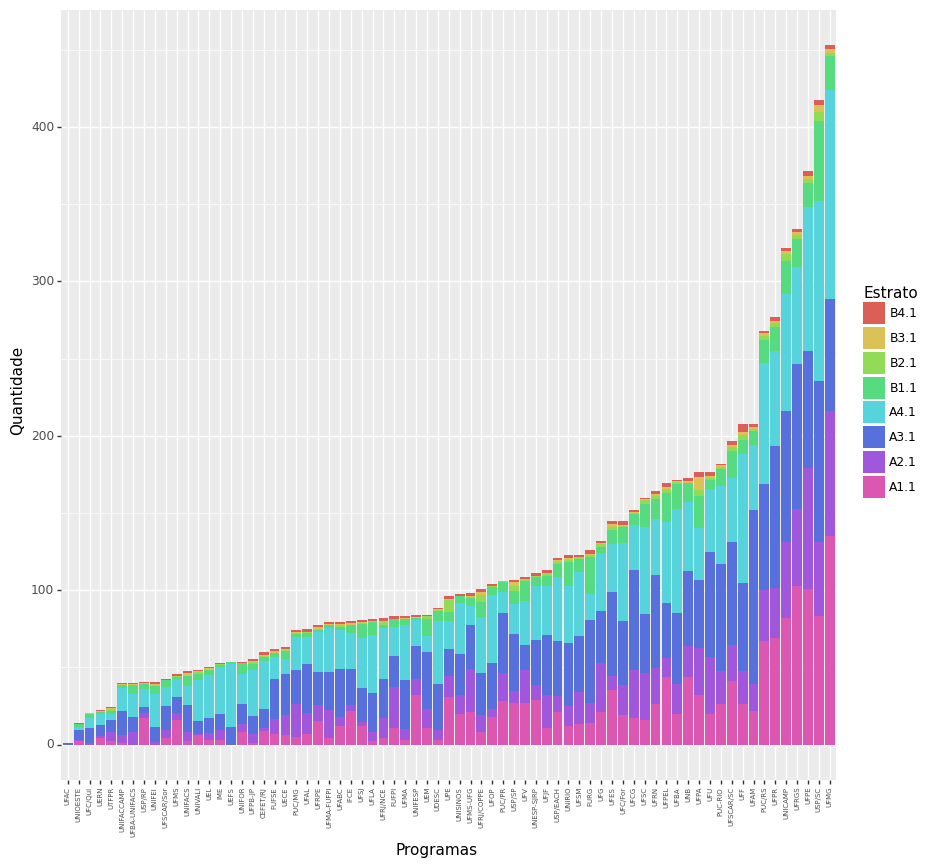

<ggplot: (8772101108629)>

In [120]:
(
    ggplot(qualis_per)
    + aes(x="Sigla_cat", y="QtePeso", fill="Estrato")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=5))
    + theme(figure_size=(10.0, 10.0))
    + labs(x="Programas", y="Quantidade", legend="Estratos")
)